## 기계학습을 이용한 유방암 진단
* 5547장의 50*50px의 조직 사진을 이용하여 유방암 진단을 하는 모델 제작
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sb

In [2]:
X = np.load('./Breast_Histology_images/X.npy')
Y = np.load('./Breast_Histology_images/Y.npy')

In [3]:
# 5547 Breast Histology images
# Y에서 0: no cancer, 1: cancer
X.shape, Y.shape

((5547, 50, 50, 3), (5547,))

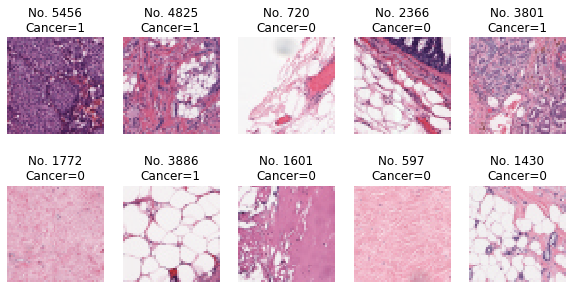

In [4]:
# 무작위 10명의 사진을 2*5 형태로 출력
fig, axes = plt.subplots(2, 5, figsize = (10,5))
for n,ax in enumerate(np.ravel(axes)):
    
    i = np.random.randint(5547)
    ax.imshow(X[i,:,:,:])
    ax.set_title('No. %d\nCancer=%d'%(i,Y[i]))
    
    ax.axis('off')
plt.show()

---
### PCA 분석
> n*m 배열의 데이터는 서로 다른 값을 가지나, 특정 규칙에 따라 분류되는 경우가 있다.<br>
n과 m 사이의 변이 규칙을 찾아내는데 PCA 분석을 사용할 수 있다.

* PCA(Principal Component Analysis, 주성분 분석): 고차원 데이터 집합을 가장 비슷한 하위 차원으로 변환하는 차원 축소법
* 유방암 조직 데이터에서는 이미지를 구성하는 50*50*3개 요소를 2개로 축소시키는 방식으로 적용할 것
---

In [5]:
#reshape. X의 차원을 5547*50*50*3에서 5547*7500개 배열의 2차원으로 변환
X_reshape = np.reshape(X,(X.shape[0],X.shape[1]*X.shape[2]*X.shape[3]))

#reshape한 변수의 요소를 2개로 감소시키기 위한 PCA 설정
pca = PCA(n_components=2)
X_reshape_pca = pca.fit_transform(X_reshape)
X_reshape_pca.shape

(5547, 2)

In [6]:
#PC1, PC2, class(암 발병 여부)로 구성된 dataframe 제작
df_pca = pd.DataFrame(data = X_reshape_pca, columns = ['PC1','PC2'])
df_pca['class'] = Y

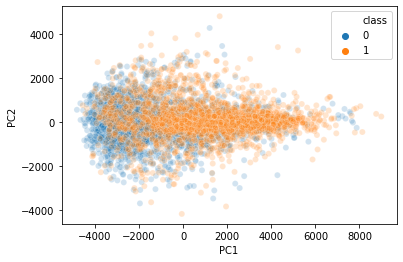

In [7]:
sb.scatterplot(df_pca['PC1'], df_pca['PC2'], hue = df_pca['class'], alpha=0.2)
#암 발생 sample이 중심부에 많이 분포해 있는 것을 확인할 수 있다

---
### Gradient Boosting Model
* 결정 트리 학습법의 일종인 부스트 트리
* 회귀 분석과 분류에 이용할 수 있다
* 랜덤포레스트에 비해 민감하지만, parameter 설정을 잘 한다면 더 높은 정확도를 제공한다고 함
* 일부 특성을 무시하는 경향이 있어 안정적이지 않음
---

In [8]:
pca = PCA(n_components=20) #20개 feature로 재구성
X_pca2 = pca.fit_transform(X_reshape)

In [9]:
df_X = pd.DataFrame(X_pca2)

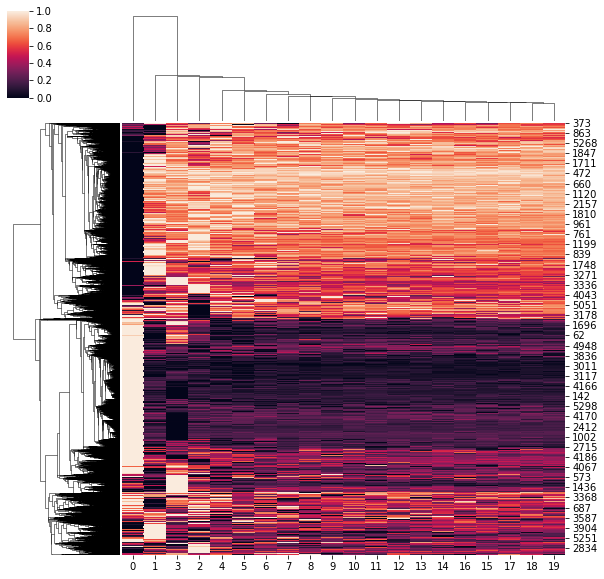

In [10]:
sb.clustermap(df_X, standard_scale=0)
#해당 데이터의 경우, feature에 따라 분류할 수 있을 것으로 보임

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_pca2,Y) #train set, test set으로 데이터 분류

In [12]:
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1) #해당 자료를 이용해 기계학습

In [13]:
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [14]:
gb.score(X_train, y_train) #train set에서의 정확도

0.9829326923076923

In [15]:
gb.score(X_test,y_test)    #test set에서의 정확도

0.7656813266041816

Text(0, 0.5, 'Feature importances')

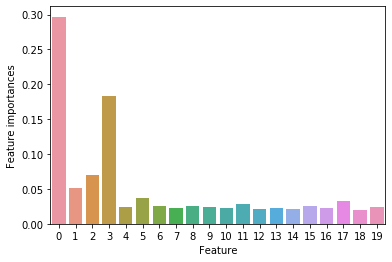

In [16]:
#feature importances를 그래프로 표시
index = df_X.columns.values

sb.barplot(index, gb.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Feature importances')